# test EP

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
from tramp.models import FactorModel
from tramp.models import GeneralizedLinearModel, MultiLayerModel
from tramp.priors import GaussianPrior, GaussBernouilliPrior, BinaryPrior
from tramp.likelihoods import GaussianLikelihood, SngLikelihood, AbsLikelihood
from tramp.channels import GaussianChannel, AbsChannel, SngChannel, LinearChannel, RotationChannel
from tramp.channels import ConcatChannel, DuplicateChannel

In [3]:
from tramp.algos import ExpectationPropagation, StateEvolution, ExplainMessagePassing
from tramp.algos import LogProgress, TrackErrors, JoinCallback, EarlyStopping
from tramp.algos import ConstantInit, NoisyInit

# Debug with gaussian denoiser

generative_model = MultiLayer(
  GaussianPrior(size=10,mean=0,var=1),
  GaussianChannel(var=5),
  observed=False
)


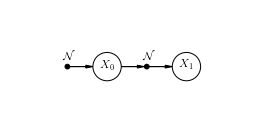

In [4]:
# generative model
N, var_prior, var_noise = 10, 1, 5

prior = GaussianPrior(size=N, var=var_prior)
out_channel = GaussianChannel(var=var_noise)
generative_model = MultiLayerModel([prior, out_channel])
print(f"generative_model = {generative_model}")
generative_model.daft()

In [5]:
# second moments
generative_model.second_moment()
for variable in generative_model.variables:
    print(variable, generative_model.model_dag.node[variable])

BridgeVariable(id=0,size=10) {'type': 'variable', 'tau': 1}
FinalVariable(id=1,size=10) {'type': 'variable', 'tau': 6}


In [6]:
# data
sample = generative_model.sample()
X, y = sample[0]["X"], sample[1]["X"]
print(f"X={X}\ny={y}")

X=[-0.88885969 -1.15266747  0.37800166  0.43306125 -1.84352328 -1.90609952
  1.60466638 -1.69496497  0.72645914  1.54358359]
y=[ 4.12437825 -4.67126316 -0.15785221  4.87977968 -2.16562311 -4.63235804
 -0.72681326 -1.70126201 -0.62065323  4.6660898 ]


model = MultiLayer(
  GaussianPrior(size=10,mean=0,var=1),
  GaussianLikelihood(size=10,var=5),
  observed=True
)


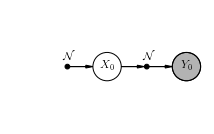

In [7]:
# inference model
likelihood = GaussianLikelihood(y=y, var=var_noise)
model = MultiLayerModel([prior, likelihood])
print(f"model = {model}")
model.daft()

In [8]:
# second moments
model.second_moment()
for variable in model.variables:
    print(variable, model.model_dag.node[variable])

BridgeVariable(id=0,size=10) {'type': 'variable', 'tau': 1}


In [9]:
# theory
def theory(var_prior, var_noise):
    v = 1 / (1/var_prior + 1/var_noise)
    return v
print(f"theory v={theory(var_prior, var_noise):.3f}")

theory v=0.833


In [10]:
explain = ExplainMessagePassing(model)
explain.run()

INFO:root:init message dag with ConstantInit(a=1,b=0)


FORWARD PASS
------------
GaussianPrior(size=10,mean=0,var=1): incoming message
GaussianPrior(size=10,mean=0,var=1)<-BridgeVariable(id=0,size=10)
GaussianPrior(size=10,mean=0,var=1): outgoing message
GaussianPrior(size=10,mean=0,var=1)->BridgeVariable(id=0,size=10)
BridgeVariable(id=0,size=10): incoming message
GaussianPrior(size=10,mean=0,var=1)->BridgeVariable(id=0,size=10)
BridgeVariable(id=0,size=10)<-GaussianLikelihood(size=10,var=5)
BridgeVariable(id=0,size=10): outgoing message
BridgeVariable(id=0,size=10)->GaussianLikelihood(size=10,var=5)
GaussianLikelihood(size=10,var=5): incoming message
BridgeVariable(id=0,size=10)->GaussianLikelihood(size=10,var=5)
GaussianLikelihood(size=10,var=5): outgoing message
[]
BACKWARD PASS
-------------
GaussianLikelihood(size=10,var=5): incoming message
BridgeVariable(id=0,size=10)->GaussianLikelihood(size=10,var=5)
GaussianLikelihood(size=10,var=5): outgoing message
BridgeVariable(id=0,size=10)<-GaussianLikelihood(size=10,var=5)
BridgeVariable(

In [11]:
ep = ExpectationPropagation(model)
ep.iterate(
    max_iter=1, callback=LogProgress(every=1),initializer=ConstantInit(a=0.002,b=0)
)

INFO:root:init message dag with ConstantInit(a=0.002,b=0)
INFO:root:iteration=1/1
INFO:root:variable=BridgeVariable(id=0,size=10) v=0.833
INFO:root:n_iter=1


In [12]:
se = StateEvolution(model)
se.iterate(
    max_iter=1, callback=LogProgress(every=1),initializer=ConstantInit(a=0.002,b=0)
)

INFO:root:init message dag with ConstantInit(a=0.002,b=0)
INFO:root:iteration=1/1
INFO:root:variable=BridgeVariable(id=0,size=10) v=0.833
INFO:root:n_iter=1


# Linear regression

generative_model = MultiLayer(
  GaussianPrior(size=1000,mean=0,var=2),
  LinearChannel(Nx=2000,Nz=1000),
  GaussianChannel(var=1),
  observed=False
)


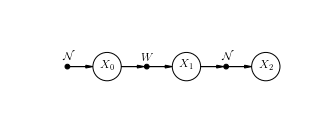

In [13]:
# generative model
N, M, var_prior, var_noise = 1000, 2000, 2, 1

prior = GaussianPrior(size=N, var=var_prior)
W = np.random.randn(M, N)/np.sqrt(N)
channel = LinearChannel(W)
out_channel = GaussianChannel(var=var_noise)
generative_model = MultiLayerModel([prior, channel, out_channel])
print(f"generative_model = {generative_model}")
generative_model.daft()

In [14]:
# data
sample = generative_model.sample()
x, z, y = sample[0]["X"], sample[1]["X"], sample[2]["X"]
print(f"x={x.shape}\nz={z.shape}\ny={y.shape}")

x=(1000,)
z=(2000,)
y=(2000,)


model = MultiLayer(
  GaussianPrior(size=1000,mean=0,var=2),
  LinearChannel(Nx=2000,Nz=1000),
  GaussianLikelihood(size=2000,var=1),
  observed=True
)


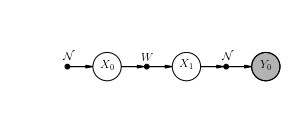

In [15]:
# inference model
likelihood = GaussianLikelihood(y=y, var=var_noise)
model = MultiLayerModel([prior, channel, likelihood])
print(f"model = {model}")
model.daft()

In [16]:
# theory
def theory(W, var_prior, var_noise, alpha):
    # linear estimation y=Wx
    az = 1/var_prior
    ay = 1/var_noise
    C = W.T @ W
    spectrum = np.linalg.eigvalsh(C)
    resolvent = 1/(az + ay*spectrum)
    vz = resolvent.mean()
    # vy = (Ny / Nx) * (1 - az * vz) / ax et Nz=N Ny=M
    vy = (1/alpha) * (1 - az * vz) / ay
    return vz, vy

v0, v1 = theory(W, var_prior, var_noise, alpha=M/N)
print(f"theory v0={v0:.3f} v1={v1:.3f}")

theory v0=0.562 v1=0.359


In [17]:
ep = ExpectationPropagation(model)
logger.setLevel(logging.INFO)
ep.iterate(
    max_iter=2, callback=LogProgress(every=1), initializer=ConstantInit()
)

INFO:root:init message dag with ConstantInit(a=1,b=0)
INFO:root:iteration=1/2
INFO:root:variable=BridgeVariable(id=0,size=1000) v=0.562
INFO:root:variable=BridgeVariable(id=1,size=2000) v=0.359
INFO:root:n_iter=1
INFO:root:iteration=2/2
INFO:root:variable=BridgeVariable(id=0,size=1000) v=0.562
INFO:root:variable=BridgeVariable(id=1,size=2000) v=0.359
INFO:root:n_iter=2


## testing warm start

In [18]:
# testing warm start
ep.iterate(
    max_iter=2, callback=LogProgress(every=1), warm_start=True
)
print(f"total iter = {ep.n_iter}")

INFO:root:warm start with n_iter=2 - no initialization
INFO:root:iteration=1/2
INFO:root:variable=BridgeVariable(id=0,size=1000) v=0.562
INFO:root:variable=BridgeVariable(id=1,size=2000) v=0.359
INFO:root:n_iter=3
INFO:root:iteration=2/2
INFO:root:variable=BridgeVariable(id=0,size=1000) v=0.562
INFO:root:variable=BridgeVariable(id=1,size=2000) v=0.359
INFO:root:n_iter=4


total iter = 4


## testing callbacks

In [19]:
for data in sample:
    print(f"id={data['id']} variable={data['variable']} shape={data['X'].shape}")

id=0 variable=BridgeVariable(id=0,size=1000) shape=(1000,)
id=1 variable=BridgeVariable(id=1,size=2000) shape=(2000,)
id=2 variable=FinalVariable(id=2,size=2000) shape=(2000,)


In [20]:
tracker = TrackErrors(true_values=sample[:2])
callback = JoinCallback(
    [LogProgress(every=1), tracker, EarlyStopping(tol=1e-11)]
)
callback

JoinCallback(
	callbacks=[LogProgress(every=1), TrackErrors(metric=mse,every=1), EarlyStopping(tol=1e-11)]
)

In [21]:
ep.iterate(
    max_iter=4, callback=callback, warm_start=False
)

INFO:root:init message dag with ConstantInit(a=1,b=0)
INFO:root:iteration=1/4
INFO:root:variable=BridgeVariable(id=0,size=1000) v=0.562
INFO:root:variable=BridgeVariable(id=1,size=2000) v=0.359
INFO:root:n_iter=1
INFO:root:iteration=2/4
INFO:root:variable=BridgeVariable(id=0,size=1000) v=0.562
INFO:root:variable=BridgeVariable(id=1,size=2000) v=0.359
INFO:root:tolerances max=0.00e+00 min=0.00e+00
INFO:root:all tolerances are below tol=1.00e-11
INFO:root:n_iter=2
INFO:root:terminated after n_iter=2 iterations


In [22]:
tracker.errors[-1]

[{'id': 0, 'mse': 0.54811329998660951}, {'id': 1, 'mse': 0.37996354262562004}]

# Long chain

generative_model = MultiLayer(
  BinaryPrior(size=10,p_pos=0.5),
  GaussianChannel(var=1),
  LinearChannel(Nx=5,Nz=10),
  AbsChannel(),
  RotationChannel(N=5),
  SngChannel(),
  GaussianChannel(var=1),
  SngChannel(),
  observed=False
)


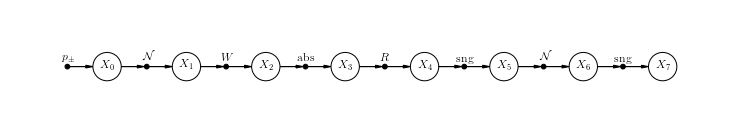

In [23]:
# generative model
from scipy.stats import special_ortho_group
N, M = 10, 5
W = np.random.randn(M, N)
R = special_ortho_group.rvs(M)

generative_model = MultiLayerModel([
    BinaryPrior(size=N), GaussianChannel(), LinearChannel(W), AbsChannel(),
    RotationChannel(R), SngChannel(),  GaussianChannel(), SngChannel()
])
print(f"generative_model = {generative_model}")
generative_model.daft()

In [24]:
# data
sample = generative_model.sample()
x, y = sample[0]["X"], sample[-1]["X"]
print(f"x={x}")
zs = [z["X"] for z in sample[1:-1]]
for i, z in enumerate(zs):
    print(f"z_{i+1}={z}")
print(f"y={y}")

x=[ 1 -1 -1 -1 -1  1  1 -1  1  1]
z_1=[ 2.02154109 -1.4130061  -1.39867921 -1.04659831 -1.98381565 -0.06606376
  0.64760153 -1.78261261 -1.08685084 -0.73001593]
z_2=[-4.24083721  0.0349094   6.0070395  -2.30631689  1.73885652]
z_3=[ 4.24083721  0.0349094   6.0070395   2.30631689  1.73885652]
z_4=[ 4.17938413  2.79614503  0.28228136 -5.57249257  2.44849488]
z_5=[ 1.  1.  1. -1.  1.]
z_6=[ 0.10669201  1.51353804  0.94544878 -0.74785193  1.24339596]
y=[ 1.  1.  1. -1.  1.]


model = MultiLayer(
  BinaryPrior(size=10,p_pos=0.5),
  GaussianChannel(var=1),
  LinearChannel(Nx=5,Nz=10),
  AbsChannel(),
  RotationChannel(N=5),
  SngChannel(),
  GaussianChannel(var=1),
  SngLikelihood(size=5),
  observed=True
)


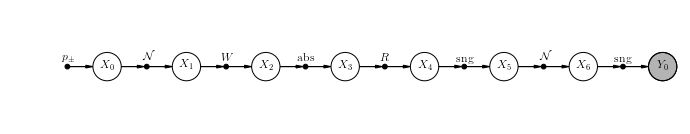

In [25]:
# inference model
likelihood = SngLikelihood(y=y)
model = MultiLayerModel(
    generative_model.layers[:-1]+[likelihood]
)
print(f"model = {model}")
model.daft()

In [26]:
sample[:2]

[{'X': array([ 1, -1, -1, -1, -1,  1,  1, -1,  1,  1]),
  'id': 0,
  'variable': BridgeVariable(id=0,size=10)},
 {'X': array([ 2.02154109, -1.4130061 , -1.39867921, -1.04659831, -1.98381565,
         -0.06606376,  0.64760153, -1.78261261, -1.08685084, -0.73001593]),
  'id': 1,
  'variable': BridgeVariable(id=1,size=10)}]

In [27]:
ep = ExpectationPropagation(model)
logger.setLevel(logging.INFO)
tracker = TrackErrors(true_values=sample[:2])
callback = JoinCallback(
    [LogProgress(every=5), tracker, EarlyStopping(tol=1e-11)]
)
callback

JoinCallback(
	callbacks=[LogProgress(every=5), TrackErrors(metric=mse,every=1), EarlyStopping(tol=1e-11)]
)

In [28]:
ep.iterate(
    max_iter=20, callback=callback, initializer=NoisyInit(a_mean=1, a_var=0.1, b_var=0)
)

INFO:root:init message dag with NoisyInit(a_mean=1,a_var=0.1,b_mean=0,b_var=0)
INFO:root:iteration=1/20
INFO:root:variable=BridgeVariable(id=0,size=10) v=-7.917
INFO:root:variable=BridgeVariable(id=1,size=10) v=-8.051
INFO:root:variable=BridgeVariable(id=2,size=5) v=9.781
INFO:root:variable=BridgeVariable(id=3,size=5) v=0.445
INFO:root:variable=BridgeVariable(id=4,size=5) v=0.445
INFO:root:variable=BridgeVariable(id=5,size=5) v=0.817
INFO:root:variable=BridgeVariable(id=6,size=5) v=1.251
INFO:root:n_iter=1
INFO:root:tolerances max=9.83e+01 min=3.21e-01
INFO:root:n_iter=2
INFO:root:tolerances max=3.29e+01 min=2.87e-04
INFO:root:n_iter=3
INFO:root:tolerances max=6.40e-01 min=1.84e-06
INFO:root:n_iter=4
INFO:root:tolerances max=9.62e-03 min=5.71e-08
INFO:root:n_iter=5
INFO:root:iteration=6/20
INFO:root:variable=BridgeVariable(id=0,size=10) v=1.000
INFO:root:variable=BridgeVariable(id=1,size=10) v=2.000
INFO:root:variable=BridgeVariable(id=2,size=5) v=18.587
INFO:root:variable=BridgeVariab

In [29]:
tracker.errors[-1]

[{'id': 0, 'mse': 1.0}, {'id': 1, 'mse': 1.8386038601844028}]

In [30]:
variables_data = ep.get_variables_data()

In [31]:
variables_data[0]

{'id': 0,
 'n_iter': 0,
 'r': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'tau': 1.0,
 'type': 'variable',
 'v': 0.99999999055260169,
 'variable': BridgeVariable(id=0,size=10)}

In [32]:
sample[0]

{'X': array([ 1, -1, -1, -1, -1,  1,  1, -1,  1,  1]),
 'id': 0,
 'variable': BridgeVariable(id=0,size=10)}